# Shifted window transformers

<script async defer src="https://buttons.github.io/buttons.js"></script>
<a class="github-button" href="https://github.com/stratisMarkou/random-walks" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-star" data-size="large" aria-label="Star stratisMarkou/random-walks on GitHub" style="float: right;">Star</a>
<a class="github-button" href="https://github.com/stratisMarkou/random-walks/issues" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-issue-opened" data-size="large" aria-label="Issue stratisMarkou/random-walks on GitHub">Issue</a>
<a class="github-button" href="https://github.com/stratisMarkou/random-walks/subscription" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-eye" data-size="large" aria-label="Watch stratisMarkou/random-walks on GitHub">Watch</a>
<a class="github-button" href="https://github.com/stratisMarkou" data-color-scheme="no-preference: light; light: light; dark: dark;" data-size="large" aria-label="Follow @stratisMarkou on GitHub">Follow</a>


[Transformers](../transformers/transformers.ipynb) are an extremely flexible deep architecture which has impacted a range of machine learning applications.
Arguably, the impact of the transformer is due to a combination of its expressivity and its flexibility: it can easily be applied to different data modalities with minimal implementation changes.
The feature that distinguishes the transformer over other architectures is its attention layer.
Attention allows the transformer block to update the features of its input tokens in a way that depends on the features themselves, making the overall architecture highly expressive.
Further, given pre-tokenised data, attention can be straightforwardly applied and many of the details of the data can be abstracted away, which means that the transformer can be easily applied to a range of modalities such as text, images, graphs and many more.

However, one important limitation of atention is that its computation and memory costs scale quadratically with the number of tokens.
This makes standard transformers difficult to scale to inputs with many tokens such as, for example, long sentences or large images.
The shifted window transformer (Swin) {cite}`liu2021swin` is an architecture which helps mitigate the issues of computational and memory complexity.
Swin was originally formulated to tackle image data, on which we focus here, but note that the main idea behind Swin is also applicable to other data modalities such as text or, more generally, any kind of gridded data.

The innovation of the Swin transformer is to apply attention in a local way, such that only tokens which are near each other (in some appropriate sense of closeness) are allowed to attend to one another.
In this sense Swin transformers are somewhat similar to convolutional neural networks (CNNs), where each input pixel affects only a local neighbourhood of output pixels at each layer of the network.
This reduces the computational cost of the Swin transformer from quadratic to linear in the number of input tokens allowing scaling to large numbers of tokens.

## Windowed self-attention
The main bottleneck in scaling transformers to large numbers of tokens is the self-attention operation.
Given $N$ tokens, simply building an $N \times N$ attention matrix requires $\mathcal{O}(N^2)$ compute and memory, which gets very expensive very quickly for large images.


:::{margin}
Note that we are using the words _chunks_ and _windows_ to distinguish from the word _patches_.
A window in a Swin transformer may contain several patches, each of which may contain several input tokens, e.g. pixels.
:::
The idea behind the Swin transformer is to modify the self-attention operation, by breaking up an input image into smaller chunks, or windows, and having each token attend to all other tokens within its window, and to no other tokens outside it, as illustrated in {numref}`swin:vit_vs_swin`.

```{figure} ./swin_vs_vit.png
---
height: 150px
name: swin:vit_vs_swin
---
Comparison of the self-attention operations in a standard vision transformer (left) and a Swin transformer (right).
Each gray square corresponds to a token, and red boxes mark groups of tokens over which attention is applied.
```


Whereas in a standard vision transformer (left) each token (gray squares) attends to every other token in the image (large red square), in a Swin transformer each token attends only to those tokens within its window (smaller red squares), and none outside it.
This significantly reduces the size of the attention matrices that need to be calculated.
For example in the ViT in the illustration above, we have $64$ tokens, resulting in a $64 \times 64$ attention matrix which has $4096$ entries.
Breaking these up into four independent windows means each attention window contains $16$ tokens, resulting in four $16 \times 16$ attention matrices with $256$ entries, for a total of $1024$ attention matrix entries across all four windows - a factor of $4$ lower.
These savings become much more significant for larger images, and increase as the window size is reduced.
However, this approach has a problem: tokens across different windows do not affect each other, which is a problem.
Swin gets around this issue by shifting the windows.

## Shifted windows
:::{margin}
Note that applying a transformer block with shifted attention windows is equivalent to shifting the image first and applying the transformer block on the original windows.
:::
In order to allow information to propagate across windows, Swin uses window shifting.
Specifically, each windowed transformer block is followed by a window shifting operation.
The next windowed transformer block is applied on the shifted windows and is followed by a reverse shift operation, which brings the windows back to their original positions.
This is illustrated by {numref}`swin:shifting`.
Since the original and shifted windows overlap, information can propagate across tokens from different windows.

```{figure} ./swin_two_windows.png
---
height: 160px
name: swin:shifting
---
Illustration of shifted attention layers in Swin.
Transformer blocks with standard attention windows (first) are interleaved with blocks using shifted windows (second).
This enables information to propagate across windows.
```

The only remaining question is how to handle windows that are cut short at the image boundaries when applying a shifting operation.
Swin handles this by applying cyclic boundary conditions, which group together the window parts that are cut short at the boundaries.
This is illustrated by {numref}`swin:cyclic`.

```{figure} ./cyclic_shifts.png
---
height: 160px
name: swin:cyclic
---
Illustration of a shifted window block in Swin.
The colours correspond to groups of tokens which attend to one another within the shifted block.
Faint colours denote pixel values before and after the application of the transformer block itself.
Given an input image (first) we apply a shift of two pixels (half the window size of four pixels) downwards and rightwards, which groups together tokens along the boundaries of the image (second).
We then apply the transformer block to the shifted image (third) followed by the reverse shifting operation, which brings back the tokens in their original positions (right).
This procedure, i.e. shifting the image and applying a transformer block with regular attention windows, is equivalent to applying a transformer block with shifted attention windows.
```

With these ideas in mind, we are ready to implement a Swin transformer!

## Implementation

The implementation of a Swin transformer is relatively simple, and requires only a minimal set of changes over a regular transformer.
In fact, we can reuse most of the code from the [introduction to transformers example](../transformers/transformers.ipynb) (see dropdown below).

In [2]:
from typing import Optional, List

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
tfk = tf.keras

# Type for random seed
Seed = [tf.Tensor, tf.Tensor]

class SelfAttention(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        projection_dim: int,
        name: str = "self_attention",
        **kwargs,
    ):

        super().__init__(name=name, **kwargs)

        # Split the seed and set up the dense layers
        seed1, seed2 = tfp.random.split_seed(seed, 2)

        self.Uk = tfk.layers.Dense(
            projection_dim,
            activation="gelu",
            use_bias=False,
            kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed1[0])),
        )

        self.Uq = tfk.layers.Dense(
            projection_dim,
            activation="gelu",
            use_bias=False,
            kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed2[0])),
        )


    def self_attention_weights(self, x: tf.Tensor) -> tf.Tensor:
        """
        Compute self-attention weights for tokens in a sequence

        Args:
            x: input sequence of tokens, shape (B, N, D)
        
        Returns:
            attention weights, shape (B, N, N)
        """
        k = self.Uk(x)
        q = self.Uq(x)

        dot_product = tf.matmul(k, q, transpose_b=True)
        dot_product /= tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))

        return tf.nn.softmax(dot_product, axis=1)
    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply self-attention to a sequence of tokens

        Args:
            x: input sequence of tokens, shape (B, N, D)

        Returns:
            output sequence of tokens, shape (B, N, D)
        """
        return tf.matmul(self.self_attention_weights(x), x, transpose_a=True)


class MultiHeadSelfAttention(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        token_dim: int,
        projection_dim: int,
        num_heads: int,
        name: str = "multi_head_self_attention",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        keys = tfp.random.split_seed(seed, 2*num_heads)
        self.self_attention = [
            SelfAttention(
                seed=key,
                projection_dim=projection_dim,
            ) for key in keys[::2]
        ]

        self.linear = [
            tfk.layers.Dense(
                token_dim,
                use_bias=False,
                activation=None,
                kernel_initializer=tf.initializers.GlorotNormal(seed=int(key[0])),
            ) for key in keys[1::2]
        ]

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply multi-head self-attention to a sequence of tokens

        Args:
            x: input sequence of tokens, shape (B, N, D)

        Returns:
            output sequence of tokens, shape (B, N, D)
        """
            
        # Compute tokens for each head and apply linear 
        heads = [
            linear(sa(x))
            for sa, linear in zip(self.self_attention, self.linear)
        ]

        # Stack and sum across heads
        return tf.reduce_mean(tf.stack(heads, axis=2), axis=2)


class MLP(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        num_hidden: int,
        num_layers: int,
        num_output: Optional[int] = None,
        name: str = "mlp",
        **kwargs,
    ):

        super().__init__(name=name, **kwargs)

        # Set up output dimensions of linear layers
        out_feats = [num_hidden] * num_layers + [num_output]

        # Split the random key into sub-keys for each layer
        seeds = tfp.random.split_seed(seed, num_layers+1)

        self.linear = [
            tfk.layers.Dense(
                out_feat,
                activation=None,
                kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed[0])),
            )
            for seed, out_feat in zip(seeds, out_feats)
        ]


    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Compute forward pass through the MLP.

        Args:
            x: input tensor of shape (..., feature_dim,)
        
        Returns:
            output tensor of shape (..., feature_dim,)
        """
        for layer in self.linear[:-1]:
            x = layer(x)
            x = tf.nn.gelu(x)
        return self.linear[-1](x)


class TransformerBlock(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        token_dimension: int,
        mlp_num_hidden: int,
        mlp_num_layers: int,
        num_heads: int,
        name: str = "swin_transformer_block",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        key1, key2 = tfp.random.split_seed(seed, 2)
        self.mhsa = MultiHeadSelfAttention(
            seed=key1,
            token_dim=token_dimension,
            projection_dim=token_dimension,
            num_heads=num_heads,
        )

        self.mlp = MLP(
            seed=key2,
            num_hidden=mlp_num_hidden,
            num_layers=mlp_num_layers,
            num_output=token_dimension,
        )

        self.ln1 = tfk.layers.LayerNormalization(axis=2)
        self.ln2 = tfk.layers.LayerNormalization(axis=2)

    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply the transformer block to input tokens `x`.

        Arguments:
            x: input tensor of shape (B, N, D)

        Returns:
            output tensor of shape (B, N, D)
        """
        x = x + self.mhsa(self.ln1(x))
        x = x + self.mlp(self.ln2(x))

        return x
    

class ImageTokeniser(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        token_dimension: int,
        patch_size: int,
        name: str = "image_tokeniser",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        assert patch_size == 1 or patch_size % 2 == 0, "Patch size must be one or even"

        self.conv = tfk.layers.Conv2D(
            filters=token_dimension,
            kernel_size=(patch_size, patch_size),
            strides=(patch_size, patch_size),
            padding="VALID",
            activation=None,
            data_format="channels_last",
            kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed[0])),
        )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """Tokenise the image `x`, applying a strided convolution.
        This is equivalent to splitting the image into patches,
        and then linearly projecting each one of these using a
        shared linear projection.

        Arguments:
            x: image input tensor of shape (B, W, H, C)

        Returns:
            output tensor of shape (B, N, D)
        """

        assert (
            x.shape[1] % self.conv.kernel_size[0] == 0
            and x.shape[2] % self.conv.kernel_size[1] == 0
        ), (
            f"Input dimensions must be divisible by patch size, "
            f"found {x.shape=} and {self.conv.kernel_size}."
        )

        return self.conv(x)
    

class PositionEmbedding(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        token_dimension: int,
        height: int,
        width: int,
        name: str = "position_embedding",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)
        
        self.embeddings = tf.Variable(
            tf.random.normal(
                (height, width, token_dimension),
                seed=int(seed[0]),
            )
        )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """Add position embeddings to input tensor.

        Arguments:
            x: input tensor of shape (B, H, W, D)

        Returns:
            output tensor of shape (B, H, W, D)
        """
        return x + self.embeddings[None, :, :, :]

### Window extraction

The only two Swin-specific pieces we need are methods for extracting and combining windows from a given image, and a method for shifting the image.
To extract the attention windows from a batch of images of shape `(B, H, W, D)`, say of dimension `(S, S)`, we can reshape the input batch to `(B, H//S, S, W//S, S, D)`.
Indexing `[b, h, a, w, b, d]` in the resulting array corresponds to indexing the `[a, b]` entry within the patch indexed by `[h, w]` within the image indexed by `[b]`.
We can transpose the resulting array to `(B, H//S, W//S, S, S, D)` and reshape it into `(B*(H//S)*(W//S), S, S, D)`, which folds all the window indices into the batch index.
Applying a regular all-to-all transformer block to the resulting array is equivalent to windowed attention where all entries in a window attend to one another, but there is no attention across windows, over which we parallelise together with the batch dimension.

In [3]:
def extract_windows(x: tf.Tensor, window_size: int) -> tf.Tensor:
    """Extract non-overlapping windows from input tensor `x`.

    Arguments:
        x: input tensor of shape

    Returns:
        output tensor of shape (B*(H//2)*(W//2), 4, D)
    """
    B = tf.shape(x)[0]
    H = tf.shape(x)[1]
    W = tf.shape(x)[2]
    D = tf.shape(x)[3]
    S = window_size

    x = tf.reshape(x, [B, H//S, S, W//S, S, D])
    x = tf.transpose(x, [0, 1, 3, 2, 4, 5])  # (B, H//S, W//S, S, S, D)
    x = tf.reshape(x, [B*(H//S)*(W//S), S**2, D])
    return x


def combine_windows(
        x: tf.Tensor,
        original_shape: tf.Tensor,
        window_size: int,
    ) -> tf.Tensor:
    """Combine windows extracted from input tensor `x`.

    Arguments:
        x: input tensor of shape (B*(H//2)*(W//2), 4, D)
        x_shape: shape of original tensor

    Returns:
        output tensor of shape (B, H, W, D)
    """
    B = original_shape[0]
    H = original_shape[1]
    W = original_shape[2]
    D = original_shape[3]
    S = window_size

    x = tf.reshape(x, [B, H//S, W//S, S, S, D])
    x = tf.transpose(x, [0, 1, 3, 2, 4, 5])  # (B, H//S, S, W//S, S, D)
    x = tf.reshape(x, [B, H, W, D])
    return x

### Window shifting

The only remaining part is the shifting operation itself.
We can straightforwardly achieve this by applying cyclic boundary conditions using `tf.roll` across the image dimensions.

In [4]:
def shift_horizontally_and_vertically(x: tf.Tensor, shift: int) -> tf.Tensor:
    """Shift windows in the input tensor `x` by shift along its width and
    height. For example, using shift == 1 (and fixing an index for the B and D
    dimensions), the corresponding image would change as follows:
    
                      Original                Shifted
                 -----------------       -----------------
                |  x   x   x   o  |     |  *   +   +   +  |
                |  x   x   x   o  |     |  o   x   x   x  |
                |  x   x   x   o  |     |  o   x   x   x  |
                |  +   +   +   *  |     |  o   x   x   x  |
                 -----------------       -----------------
    
    Arguments:
        x: input tensor of shape (B, H, W, D)
        shift: amount of shift to apply

    Returns:
        output tensor of shape (B, H, W, D)
    """
    return tf.roll(tf.roll(x, shift, axis=1), shift, axis=2)

### Swin transformer block

We can put the above together into a Swin transformer block.
This applies a regular transformer block, followed by another transformer block sandwiched between a window shifting operation and its inverse.

In [5]:
class SwinTransformerBlock(tfk.Model):
    def __init__(
        self,
        seed: Seed,
        token_dimension: int,
        mlp_num_hidden: int,
        mlp_num_layers: int,
        num_heads: int,
        num_block_pairs: int,
        window_size: int,
        name: str = "swin_transformer_block", 
        **kwargs,
    ):

        super().__init__(name=name, **kwargs)

        seeds = tfp.random.split_seed(seed, 2*num_block_pairs)
        self.first_blocks = [
            TransformerBlock(
                seed=seeds[2*i],
                token_dimension=token_dimension,
                mlp_num_hidden=mlp_num_hidden,
                mlp_num_layers=mlp_num_layers,
                num_heads=num_heads,
            )
            for i in range(num_block_pairs)
        ]

        self.second_blocks = [
            TransformerBlock(
                seed=seeds[2*i+1],
                token_dimension=token_dimension,
                mlp_num_hidden=mlp_num_hidden,
                mlp_num_layers=mlp_num_layers,
                num_heads=num_heads,
            )
            for i in range(num_block_pairs)
        ]

        self.window_size = window_size


    def call(self, x: tf.Tensor) -> tf.Tensor:
        """Apply the Swin Transformer block to input tokens `x`.

        Arguments:
            x: input tensor of shape (B, H, W, D)

        Returns:
            output tensor of shape (B, H, W, D)
        """
        original_shape = tf.shape(x)
        S = self.window_size

        for first_block, second_block in zip(self.first_blocks, self.second_blocks):

            # Apply first transformer block, extracting windows, applying the
            # transformer block to them, and re-combining them to the original image.
            x = extract_windows(x, S)  # (B*H//S*W//S, S**2, D)
            x = first_block(x)  # (B*H//S*W//S, S**2, D)
            x = combine_windows(x, original_shape, S)  # (B, H, W, D)

            # Apply second transformer block same as the first block, but shifting
            # the windows before and after the block.
            x = shift_horizontally_and_vertically(x, S // 2)  # (B, H, W, D)
            x = extract_windows(x, S)  # (B*H//S*W//S, S**2, D)
            x = second_block(x)  # (B*H//S*W//S, S**2, D)
            x = combine_windows(x, original_shape, S)  # (B, H, W, D)
            x = shift_horizontally_and_vertically(x, -S // 2)  # (B, H, W, D)

        x = combine_windows(x, original_shape, S)  # (B, H, W, D)

        return x

One last, optional, ingredient that is not specific to Swin is patch merging, which can be viewed as a pooling operation, similar to mean-pooling.
Patch merging combines a collection of patches by concatenating their features channel-wise and then applying a linear operation to project these back to their original channel dimension.

In [6]:
class PatchMergingLayer(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        num_out_features: int,
        name: str = "patch_merging",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        self.linear = tfk.layers.Dense(
            num_out_features,
            activation=None,
            use_bias=False,
            kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed[0])),
        )

        self.num_out_features = num_out_features
    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """Apply patch merging to input tensor `x`.

        Arguments:
            x: input tensor of shape (B, H, W, D)

        Returns:
            output tensor of shape (B, H//2, W//2, 2*D)
        """
        x = tf.image.extract_patches(
            x,
            sizes=[1, 2, 2, 1],
            strides=[1, 2, 2, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )  # (B, H//2, W//2, 4*D)
        return self.linear(x)  # (B, H//2, W//2, 2*D)

:::{dropdown} An aside: inverse of patch extraction as transpose

While we do not need this, here is a neat aside on patch extraction, the `tf.image.extract_patches` operation in the `PatchMergingLayer` above.
One might wonder what the inverse of a patch extraction operation is, or rather how to implement it efficiently.
It turns out that patch extraction operations can't always be inverted, i.e. not for all choices of striding, window sizes and dilation, but for those settings for which an inverse exists, the inverse can be expressed and implemented in a very neat way.

__Invertibility.__
Under certain conditions patch extraction can be inverted, leveraging the fact that the reverse operation is actually its transpose.
However, there are exaples of patch extraction which are not invertible.
For example, if we use large strides and small patch sizes, or if we use dilation (also known as à trous; this is the `rate` argument in `tf.image.extract_patches`), then some of the pixels of the input image may be skipped over, making patch extraction non-invertible.
From now on, we will assume that the patch extraction is performed using a combination of patch size, striding and dilation such that every pixel in the input affects the output, and no pixels are skipped over.

__Matrix view.__
Suppose the input image $x$ is an array of shape $(H, W, C),$ where $H$ is its height, $W$ is its width and $C$ is the number of channels.
We can view patch extraction as a linear operation $P$ which maps the image $x$ to another image $y = P(x),$ of shape $(I, J, K),$ where the dimensions denote the horizontal patch index, vertical patch index and patch dimension respectively.
Note that by the definition of patch extraction, each pixel in the output is affected by exactly one pixel in the input (though each pixel in the input may affect more than one pixel in the output).
For now, let us assume that each pixel in the input affects exactly one pixel in the output, i.e. each $x_{hwc}$ affects exactly one $y_{ijk}.$
Let's define $\texttt{flat}$ to be the operation that takes a multi-dimensional array and flattens it into a single-dimensional array.
Since $\texttt{flat}$ is an invertible linear operation, and patch extraction is also an invertible linear operation, then their composition is also an invertible linear opeartion $P'.$
Let $\mathcal{M}(P')$ be the matrix corresponding to $P',$ so that

$$\texttt{flat}(y) = \mathcal{M}(P') \texttt{flat}(x).$$

Now note that since each element of $\texttt{flat}(x)$ affects precisely one element of $\texttt{flat}(y),$ the matrix $\mathcal{M}(P')$ is actually a permutation matrix, i.e. it contains exactly one $1$ in each row and in each column, and all other entries are $0.$
Now, the inverse of a permutation matrix is its transpose, that is

$$\texttt{flat}(x) = \mathcal{M}(P')^\top \texttt{flat}(y).$$

So the inverse of the patch embedding operation is actually its transpose operation, and that's because the patch embedding is actually a permutation!

__General case.__
But what happens in the more general case where some $x_{hwc}$ affect more than one $y_{ijk}$?
The equation $\texttt{flat}(y) = \mathcal{M}(P') \texttt{flat}(x)$ still holds, and the matrix $\mathcal{M}(P')$ stil contains a single $1$ per row.
However, $\mathcal{M}(P')$ may now contain multiple $1$ entries in each column.
Therefore, it is no longer a permutation matrix, and $\texttt{flat}(x) \neq \mathcal{M}(P')^\top \texttt{flat}(y).$
In particular, when we multiply $\texttt{flat}(y)$ by $\mathcal{M}(P')^\top,$ each entry of $\texttt{flat}(x)$ which affects $n$ entries in $\texttt{flat}(y)$ will be counted $n$ times.
To illustrate this problem, suppose consider the following vectors and matrices (which do not correspond to patch extraction, and are just an illustration of the problem) and the following matrix-vector multiplication

$$
u = \begin{bmatrix}
u_1 \\
u_2
\end{bmatrix}, M = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
0 & 1
\end{bmatrix} \implies v = Mu = \begin{bmatrix}
u_1 \\
u_2 \\
u_2
\end{bmatrix}.
$$

If we multiply $v = Mu$ by $M^\top$ we obtain

$$
M^\top v = M^\top Mu = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 1
\end{bmatrix} \begin{bmatrix}
u_1 \\
u_2 \\
u_2
\end{bmatrix} = \begin{bmatrix}
u_1 \\
2u_2
\end{bmatrix},
$$

i.e. we have double-counted $u_2.$
If instead we divide each row of $M^\top$ by its sum before multiplying we obtain

$$
M^\top v = \begin{bmatrix}
1 & 0 & 0\\
0 & \frac{1}{2} & \frac{1}{2}
\end{bmatrix} \begin{bmatrix}
u_1 \\
u_2 \\
u_2
\end{bmatrix} = \begin{bmatrix}
u_1 \\
u_2
\end{bmatrix},
$$

which is the desired result.
Therefore, all we have to do is divide each row of $M^\top$ by its sum, or alternatively divide each entry of $M^\top v$ by the sum of each row of $M^\top.$

__Implementation.__
We can perform all of the above in a few lines in Tensorflow, or a similar autodiff framework, as shown above.
First, the command

```
tf.gradients(y, x, grad_ys=y)[0]
```

computes the gradients of the scalar `sum(y)` with respect to `x` and multiplies these gradients together with the corresponding entries in `grad_ys`, as performed in revrse mode differentiation.
This is equivalent to the multiplication $\mathcal{M}(P')^\top \texttt{flat}(y)$ except the tensors are not actually flattened, but retain their original shapes.
Then, the command

```
tf.gradients(y, x)[0]
```

computes the derivative of `sum(y)` with respect to `x`.
If an entry in `x` affects $n$ entries in `y`, then the gradient of `sum(y)` with respect to that entry of `x` will be $n,$ so the division

```
tf.gradients(y, x, grad_ys=y)[0] / tf.gradients(y, x)[0]
```

gives the result we were after.
:::

### Putting it together
We are now ready to put all of the above together into a `TinySwinTransformer` model which handles tokenisation and position embeddings, and then applies the `SwinTransformerBlock`.

In [7]:
class TinySwinTransformer(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        tokeniser: ImageTokeniser,
        embedding: PositionEmbedding,
        token_dimension: int,
        window_size: int,
        mlp_num_hidden: int,
        mlp_num_layers: int,
        num_heads: int,
        num_classes: int,
        num_blocks_per_stage: List[int],
        name: str = "tiny_swin_transformer",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        num_stages = len(num_blocks_per_stage)
        seeds = tfp.random.split_seed(seed, 2*num_stages+1)

        self.stages = []
        self.patch_merging_layers = []

        for i, n in enumerate(num_blocks_per_stage):
            self.patch_merging_layers.append(
                PatchMergingLayer(
                    seed=seeds[2*i+1],
                    num_out_features=(2**i)*token_dimension,
                )
            )
            self.stages.append(
                SwinTransformerBlock(
                    seed=seeds[2*i],
                    token_dimension=(2**i)*token_dimension,
                    mlp_num_hidden=mlp_num_hidden,
                    mlp_num_layers=mlp_num_layers,
                    num_heads=num_heads,
                    num_block_pairs=n,
                    window_size=window_size,
                )
            )

        self.final_mlp = MLP(
            seed=seeds[-1],
            num_hidden=mlp_num_hidden,
            num_layers=mlp_num_layers,
            num_output=num_classes,
        )

        self.tokeniser = tokeniser
        self.embedding = embedding

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply vision transformer to batch of images.

        Arguments:
            x: input image tensor of shape (B, H, W, C)

        Returns:
            output logits tensor of shape (B, num_classes)
        """

        x = self.tokeniser(x)
        x = self.embedding(x)

        for patch_merging, stage in zip(self.patch_merging_layers, self.stages):
            x = patch_merging(x)
            x = stage(x)

        x = tf.reshape(x, [tf.shape(x)[0], -1, tf.shape(x)[-1]])
        x = self.final_mlp(tf.reduce_mean(x, axis=1))
        return x - tf.math.reduce_logsumexp(x, axis=1, keepdims=True)

## Example application
Now let's train and evaluate our `TinySwinTransformer` on an equally tiny example.
Because this is meant to be a demo that should run on a laptop, we'll use the MNIST dataset.


### Dataset
We'll use [tensorflow datasets](https://www.tensorflow.org/datasets/api_docs/python/tfds) to load and preprocess the MNIST data.

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds

def preprocess_image(image, label):
    image = 2. * (tf.cast(image, tf.float32) / 255.) - 1.
    image = tf.image.resize(image, [32, 32])
    return image, label

def get_batches(batch_size: int, split: str, data_dir: str="/tmp/tfds"):

    # Conversion from labels to one-hot
    def one_hot(image, label):
        return image, tf.one_hot(label, 10)

    assert split in ["train", "test"], "Split must be 'train' or 'test'"
    ds = tfds.load(
        name="mnist",
        split=split,
        as_supervised=True,
        data_dir=data_dir,
        shuffle_files=False,
    )
    ds = ds.map(preprocess_image)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    ds = ds.map(one_hot)

    return ds

## Training
Now let's train the network.
In general, when training a vision transformer, a few tricks are typically used, including for example, learning rate scheduling and data augmentation.
Dropout is also sometimes used in the architecture itself.
We won't use any of these techniques here to keep things simple.

In [9]:
@tf.function
def train_step(
    model: tfk.Model,
    images: tf.Tensor,
    labels: tf.Tensor,
    loss_fn: tf.losses.Loss,
    optimizer: tf.optimizers.Optimizer,
) -> tf.Tensor:
    
    with tf.GradientTape() as tape:
        logits = model(images)
        loss = loss_fn(labels, logits)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, logits

# Model parameters
token_dimension = 64
patch_size = 1
num_mlp_hidden = 64
num_mlp_layers = 1
num_heads = 8
num_classes = 10
window_size = 2
num_blocks_per_stage = [1, 1, 1, 1]

# Training parameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-4
weight_decay = 1e-6

# Create the tokeniser and embeddings
seeds = tfp.random.split_seed([0, 0], 3)

tokeniser = ImageTokeniser(
    seeds[0],
    token_dimension=token_dimension,
    patch_size=patch_size,
)

embedding = PositionEmbedding(
    seeds[1],
    token_dimension=token_dimension,
    height=32,
    width=32,
)

# Create a transformer
transformer = TinySwinTransformer(
    seeds[2],
    tokeniser=tokeniser,
    embedding=embedding,
    token_dimension=token_dimension,
    window_size=window_size,
    mlp_num_hidden=num_mlp_hidden,
    mlp_num_layers=num_mlp_layers,
    num_heads=num_heads,
    num_classes=num_classes,
    num_blocks_per_stage=num_blocks_per_stage,
)

# Create optimizer
optimizer = tf.optimizers.Adam(
    learning_rate=learning_rate,
    weight_decay=weight_decay,
)

# Create loss function and accuracy helpers
loss_fn = tf.losses.CategoricalCrossentropy(from_logits=True)
accuracy = tf.metrics.CategoricalAccuracy()

In [10]:
from tqdm.notebook import tqdm

# Keep track of losses and accuracies for plotting
all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []
num_steps = 0

for epoch in range(num_epochs):

    pbar = tqdm(get_batches(batch_size, "train"))

    epoch_losses = []
    epoch_accuracies = []
    for images, labels in pbar:
        loss, logits = train_step(
            transformer,
            images,
            labels,
            loss_fn,
            optimizer,
        )
        acc = accuracy(labels, logits)

        epoch_losses.append(loss)
        epoch_accuracies.append(acc)
        all_train_losses.append((num_steps, loss))
        all_train_accuracies.append((num_steps, acc))

        num_steps += 1

        pbar.set_description(
            f"Epoch ({epoch+1:03d}) "
            f"mean loss: {tf.reduce_mean(epoch_losses):.3f}, "
            f"mean accuracy: {tf.reduce_mean(epoch_accuracies):.3f}"
        )

    test_losses = []
    test_accuracies = []
    for images, labels in get_batches(batch_size, "test"):

        logits = transformer(images)
        test_losses.append(loss_fn(labels, logits))
        test_accuracies.append(accuracy(labels, logits))

    mean_loss = tf.reduce_mean(test_losses)
    mean_acc = tf.reduce_mean(test_accuracies)
    all_test_losses.append((num_steps, mean_loss))
    all_test_accuracies.append((num_steps, mean_acc))

print(
    f"Epoch {num_epochs}: "
    f"loss {mean_loss:.3f} (train {tf.reduce_mean(epoch_losses):.3f}), "
    f"acc. {mean_acc:.3f} (train {tf.reduce_mean(epoch_accuracies):.3f})"
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 5: loss 0.081 (train 0.045), acc. 0.959 (train 0.956)


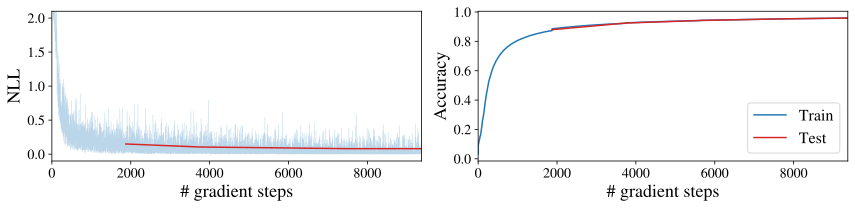

In [12]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

train_steps, train_nlls = zip(*all_train_losses)
_, train_accs = zip(*all_train_accuracies)
test_steps, test_nlls = zip(*all_test_losses)
_, test_accs = zip(*all_test_accuracies)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_nlls, color="tab:blue",linewidth=0.5, alpha=0.3)
plt.plot(test_steps, test_nlls, color="tab:red")
plt.ylim([-0.1, 2.1])
plt.xlim([0, train_steps[-1]])
plt.xlabel("# gradient steps", fontsize=18)
plt.ylabel("NLL", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(train_steps, train_accs, color="tab:blue", label="Train")
plt.plot(test_steps, test_accs, color="tab:red", label="Test")
plt.xlim([0, train_steps[-1]])
plt.xlabel("# gradient steps", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()

## Conclusion
We have looked at the details of the Swin transformer.
The Swin transformer amounts to modifying the attention operation in a regular transformer by adding windows.
All tokens within a window attend to one another and there is no attention across windows.
To allow for information to propagate across windows, Swin applies window shifting between consecutive transformer blocks.
We looked at a specific example for computer vision and trained it on MNIST.

## References

```{bibliography}
:filter: docname in docnames
```